![alt text](https://easyvvuq.readthedocs.io/en/latest/_static/circle-logo.svg)

Vytautas Jancauskas 2020

# **EasyVVUQ Tutorial**

# Introduction

In this tutorial we will show you how you can use [EasyVVUQ](https://github.com/UCL-CCS/EasyVVUQ) to investigate the properties of a simple epidemiological model. The model is very simplistic and is not intended to realisticly portray a real epidemic such as COVID-19. However it is also fun enough to experiment with and we can use it as an example to show how you can use EasyVVUQ to answer questions about your scientific models. EasyVVUQ is successfully used by researchers in various different fields, such as plasma physics, weather and air pollution modelling and materials science.

# Installing EasyVVUQ

Before we do anything else we need to install EasyVVUQ for use in this notebook. Please skip this if you already have EasyVVUQ installed in your system. This is meant for situations where this notebook is hosted externally to your local computer. We also want to clone the git repository because it contains some files used in this tutorial. Please note that you might need to restart the runtime after the installation is complete. If the following code examples don't work please try that first. I have added a command that kills the runtime (which causes it to be restarted). But I'm not sure if it will always work.

In [ ]:
!pip install git+https://github.com/UCL-CCS/EasyVVUQ

In [ ]:
!git clone https://github.com/UCL-CCS/EasyVVUQ

In [ ]:
import os
os.kill(os.getpid(), 9)

# Epidemiological Model

In our model individuals are placed on a two dimensional square grid. During each turn, the individual moves at random one square in one of eight possible directions (N, NE, E, SE, S, SW, W or NW). If the individual encounters another individual and that person is ill, the individual will also become sick for a specified number of turns (that number is a parameter to the model). Once ill, the individual cannot become sick anymore and after getting over the disease they will have immunity. Immunity means that this person cannot get infected anymore. The simulation continues until no one is sick. At that point the disease counts as erradicated.

Let us load the model and see how it operates. We create a population on a 10x10 grid containing 20 individuals. Once infected the individual can transmit the disease for 28 turns. After that they have a 20% chance of dying.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import EasyVVUQ.docs.epidemic.epidemic as epidemic

population = epidemic.Population(grid_size=10, n=20, duration=28, mortality=0.2)

The code cell below is supposed to be run multiple times. Each time you run it the image below will update to show the state of the population. The black squares are empty, the white squares represent individuals who are not immune and are not sick. The red squares represent ill individuals and the intensity of the red shows how many turns they will stay ill for. Green squares represent individuals who are immune. Once the disease is eradicated, the graphic will change to a plot showing the evolution of the disease over time.

In [ ]:
population.move()
if np.count_nonzero(population.ill):
  plt.imshow(population.get_im())
  plt.show()
else:
  plt.plot(population.ill_history, label="Sick Individuals")
  plt.plot(population.immune_history, label="Immune Individuals")
  plt.plot(population.n_history, label="Population")
  plt.xlabel("Time")
  plt.ylabel("Count")
  plt.legend()
  plt.show()

Since EasyVVUQ is meant to be a general framework (non-Python specific) we don't call Python functions directly to get results of the simulation. After all, many simulations are still written in Fortran and operate by taking an input file and producing a file with outputs of the simulation. To do statistical analysis we need to be able to provide an appropriate input file to the simulation and be able to parse the outputs of the simulation. You can run our simulation as in the following example.

In [35]:
!cd EasyVVUQ/docs/epidemic/; time python3 epidemic.py example.json output.csv


real	0m7.483s
user	0m2.115s
sys	0m0.365s


This will have produced a file called output.csv that consists of four columns labeled "iteration", "ill", "immune" and "population". These should be fairly self explanatory.

In [36]:
!cat EasyVVUQ/docs/epidemic/output.csv

iteration,ill,immune,population
0,1,0,20
1,1,0,20
2,1,0,20
3,1,0,20
4,1,0,20
5,1,0,20
6,1,0,20
7,1,0,20
8,1,0,20
9,1,0,20
10,1,0,20
11,1,0,20
12,1,0,20
13,1,0,20
14,1,0,20
15,1,0,20
16,1,0,20
17,1,0,20
18,1,0,20
19,1,0,20
20,1,0,20
21,1,0,20
22,1,0,20
23,1,0,20
24,1,0,20
25,1,0,20
26,1,0,20
27,0,0,20


Let us plot this data and see what the evolution of the disease looks like in our population.

In [ ]:
  import matplotlib.pyplot as plt
  import pandas as pd

  df = pd.read_csv("EasyVVUQ/docs/epidemic/output.csv")
  plt.plot(df['ill'], label="Sick Individuals")
  plt.plot(df['immune'], label="Immune Individuals")
  plt.plot(df['population'], label="Population")
  plt.xlabel("Time")
  plt.ylabel("Count")
  plt.legend()
  plt.show()

A short summary is in order so that we can start exploring the sample space of our model:

* We have a script that takes a JSON file with parameters and produces a CSV file with the output.
* The model takes 4 input parameters - grid size, population size, disease duration and mortality rate.
* The model produces 4 columns of output - iteration number, number of sick people, number of immune people and the current population size.

We will use EasyVVUQ to help us answer some questions about the model. Here are some simple ones that arise from toying with the model:

* Given that every time the length of time before the disease is erradicated is different even with the same parameters (due to the fact that each individual chooses where to move to at random), we might want to know, within a given certainty range, what the expected value of that is. This tells us, with needed confidence, how long we can expect the disease to last given certain parameters.
* We might also do the same thing but for a set of parameter values. Namely we might want to performa a parameter sweep with corresponding error bars.
* We might also want to improve our results by adding more samples to our analysis - hence we will see how we can restart a simulation and draw more samples to improve the accuracy.
* At some point we will want to use external resources to execute our simulations. We will quickly discuss how this can be done.
* Finally, given that our model is quite computationally expensive, we might want to explore the possibility of creating surrogate models to stand-in in place of the original model. These are usually expensive to create but very cheap to evaluate. Hence there is a possibility that we will be able to extract knowledge about our model from them that would be too expensive (computationally or otherwise) with a full simulation.

But first we need to set EasyVVUQ up to produce the configuration files in the suitable format and read in the output of the simulation. We also need to give a description of the parameter space. We also need to specify how we will execute our simulation. The next sections is concerened with these tasks.

# EasyVVUQ Set-up

For the examples in this tutorial we import some libraries that will be used throughout. EasyVVUQ will be referred to as 'uq' in the code. We also need Chaospy because we use it for the probability distribution classes. We use numpy for certain small tasks and we use pandas DataFrame as the standard data exchange format as is customary in the Python data science infrastucture.

In [1]:
import easyvvuq as uq
import chaospy as cp
import easyvvuq.collate
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path

While we are at it we also want to describe the arguments to our model. This takes a form of a Python dictionary. The dictionary is based on the Cerberus validator dictionary format. For more information refer to Cerberus [documentation](https://docs.python-cerberus.org/en/stable/). This dictionary is used in both validation of the results and for the default values when we don't want to vary a certain parameter.

In [2]:
params = {
    "grid_size": {"type": "float", "default": 10},
    "n": {"type": "float", "min": 1, "max": 100, "default": 20},
    "duration": {"type": "float", "min": 0, "max": 365, "default": 28},
    "mortality": {"type": "float", "min": 0.0, "max": 1.0, "default": 0.2},
    "ensemble" : {"type": "integer", "default": 0}
}

We will also want to set-up some elements that will stay the same for all the examples. These components are the encoder - which is responsible for creating input files for our simulation and the decoder - which is responsible for parsing the output of the simulation.

For the Encoder we use the GenericEncoder class. It is a very simple template based encoder. It finds a specified delimiter, and replaces the variable name that follows that delimiter with the corresponding value. In our case the template file looks like follows:

```
{
    "grid_size" : $grid_size,
    "n" : $n,
    "duration" : $duration,
    "mortality" : $mortality
}
```

From this template, a JSON file will be created and then passed to the simulation script as an argument. EasyVVUQ has other encoders as well. For example the [Jinja encoder](https://easyvvuq.readthedocs.io/en/dev/source/easyvvuq.encoders.html#module-easyvvuq.encoders.jinja_encoder).



In [3]:
encoder = uq.encoders.GenericEncoder(
    template_fname='EasyVVUQ/docs/epidemic/epidemic.template',
    delimiter='$',
    target_filename='epidemic_in.json')

Since the quantity of interest (number of turns until the disease is erradicated) is a function of the simulation output (it is the iteration number of the last row) we need to extend the Decoder class to take this in to account. To this end we inherit from SimpleCSV decoder and redefine the `parse_sim_output` method to take the last value of the `iteration` column in the file produced by the simulation. This gives us the length in turns for which the simulation ran or in other words before the disease disappeared in our simulation.

In [4]:
class EpidemicDecoder(uq.decoders.SimpleCSV, decoder_name='epidemic_decoder'):
    def parse_sim_output(self, run_info={}):
        result = super().parse_sim_output(run_info)
        return pd.DataFrame(result.tail(1)['iteration'])

decoder = EpidemicDecoder(
    target_filename="output.csv", output_columns=["iteration"], header=0)

We will also define a helper function that will execute the simulation with the provided input files. This function takes a campaign object, creates the directories with input files and then runs our script in them with those files as inputs. The exact details of this process can be found [here](https://easyvvuq.readthedocs.io/en/dev/source/easyvvuq.html#easyvvuq.campaign.Campaign.populate_runs_dir) and [here](https://easyvvuq.readthedocs.io/en/dev/source/easyvvuq.html#easyvvuq.campaign.Campaign.apply_for_each_run_dir).

In [ ]:
def campaign_execute(campaign):
  campaign.apply_for_each_run_dir(
      uq.actions.ExecuteLocal(
          "{} epidemic_in.json output.csv".format(
              os.path.abspath('EasyVVUQ/docs/epidemic/epidemic.py')), 
              interpret="python3"))

The collater is responsible for aggregating the outputs of the simulation. Think of it this way: the decoder produces a pandas `DataFrame` from the output of a simulation while a collater takes `DataFrames` from many simulations and produces a single `DataFrame` from them. The simplest way of doing this is to simply concatenate the `DataFrames` which is what [`AggregateSamples`](https://easyvvuq.readthedocs.io/en/dev/source/easyvvuq.collate.html#easyvvuq.collate.aggregate_samples.AggregateSamples) collater does.

In [5]:
collater = uq.collate.AggregateSamples(average=False)

## Basic Example

We start by creating an
EasyVVUQ Campaign. Here we call it 'epidemic_basic'. :

In [ ]:
campaign = uq.Campaign(name='epidemic_basic')
print(campaign)

We then want to describe our application. This means passing parameter dictionary, enoder, decoder and collater to the campaign object.

In [ ]:
# Add the app (automatically set as current app)
campaign.add_app(
    name="epidemic",
    params=params,
    encoder=encoder,
    decoder=decoder,
    collater=collater)

For this particular task we are not interested in the relationship between input parameters and the behavior of the simulation. All we want is to see how much the result varies between runs that are identical but for the random seed.

In [ ]:
from easyvvuq.sampling import EmptySampler
campaign.set_sampler(EmptySampler())

EmptySampler is a convenience class for such cases. However, another option is, if your simulation provides the option to specify different seeds, to draw the seeds from a probability distribution. In cases like these you could specify the sampler like this:

```
from easyvvuq.sampling import RandomSampler

vary = {'seed' : cp.DiscreteUniform(0, MAX_SEED)}
sampler = RandomSampler(vary)
```

In the above example `MAX_SEED` is the maximum value the seed can take plus one.


Calling the campaign's draw\_samples() method will cause the specified
number of samples to be added as runs to the campaign database, awaiting
encoding and execution. Please note that nothing is executed at this stage. Neither any changes are made to the file system (e.g. no input files are created). This happens at a later stage. If no arguments are passed to draw\_samples()
then all samples will be drawn, unless the sampler is not finite. In
this case let us try 20 samples :

In [ ]:
campaign.draw_samples(20)

Let us now create the input files for our simulations.

In [ ]:
campaign.populate_runs_dir()

We now want to execute the simulations. Please note, that after this stage the results are not yet processed. The output files are just sitting on the filesystem awaiting collation.

In [ ]:
campaign_execute(campaign)

We can now see what the result is. It will be a DataFrame containing the number of iterations before the disease is erradicated. Calling collate on the campaign object will find and parse the output files of our simulation and then produce a single DataFrame with the results.


In [ ]:
campaign.collate()
df = campaign.get_collation_result()
print(df)

This collated data is stored in the campaign database. An analysis
element, here EnsembleBoot (which performs [bootstraping](https://en.wikipedia.org/wiki/Bootstrapping_(statistics))), can then be applied to the campaign's
collation result. :

In [ ]:
analysis = uq.analysis.EnsembleBoot(qoi_cols=["iteration"], stat_func=np.mean, stat_name='mean', alpha=0.05)
campaign.apply_analysis(analysis)

The output of this is dependent on the type of analysis element. :

In [ ]:
# Get Descriptive Statistics
results = campaign.get_last_analysis()
print(results)

The above gives the mean value of the number of iterations before the disease eradication and the 95% confidence region for that estimator.

# Parameter Sweep

Suppose we want to examine the behaviour of the model by doing a sweep across a range of parameter values. Let's say that given a fixed population size and fixed mortality rate we want to see how does the model behaves if we vary the disease duration parameter from 4 days to, for example, 28 days. We will do this in 2 day increments. Also, in order to perform some kind of statistical analysis of the results we will want to do sample the same parameter set several times. We will do this using the replicas mechanism in the EasyVVUQ.

First we define a new campaign.

In [6]:
campaign = uq.Campaign(name='epidemic_sweep')
campaign.add_app(
    name="epidemic_sweep",
    params=params,
    encoder=encoder,
    decoder=decoder,
    collater=collater)

We need to define a different kind of sampler. In our case we want BasicSweep which allows one to sample an n-dimensional grid of values. In this case we specify a single parameter and give it a list of values. If you add more parameters the sampler will then sample a Cartesian product of those lists. For examples `{'a' : [1, 2], 'b' : [3, 4]}` will result in `{'a': 1, 'b': 3}`, `{'a': 1, 'b': 4}`, `{'a': 2, 'b': 3}` and `{'a': 2, 'b': 4}` being sampled.

In [7]:
sweep = {
    "duration" : list(range(2, 30, 2))
}
sweep_sampler = uq.sampling.BasicSweep(sweep=sweep)

We will also want to sample each point multiple times in order to construct confidence intervals. To this end we use a ReplicaSampler element which wraps around our `sweep_sampler`. In essence it will simply run the simulation with the same inputs multiple times with different random number generator seeds.

In [8]:
from easyvvuq.sampling import ReplicaSampler
sampler = ReplicaSampler(sweep_sampler)
campaign.set_sampler(sampler)

Finally we want to draw some samples from this new sampler.

In [9]:
campaign.draw_samples(20 * 14)
campaign.populate_runs_dir()

The following steps are the same as in our more basic example. Note that execution might take some time. That is because we are running 280 simulations on the machine that is hosting this notebook.

In [10]:
statuses = campaign.apply_for_each_run_dir(
    uq.actions.ExecuteLocalV2("{} epidemic_in.json output.csv".format(
        os.path.abspath('EasyVVUQ/docs/epidemic/epidemic.py')), interpret="python3"))

In [37]:
print(statuses.stats())

{'ready': 0, 'active': 0, 'finished': 280, 'failed': 0}


In [38]:
campaign.collate()
df = campaign.get_collation_result()
print(df)

     index  iteration  duration  ensemble  grid_size   n  mortality   run_id  \
0        0          1         2         0         10  20        0.2    Run_1   
1        1          3         4         1         10  20        0.2    Run_2   
2        2          6         6         2         10  20        0.2    Run_3   
3        3         12         8         3         10  20        0.2    Run_4   
4        4         23        10         4         10  20        0.2    Run_5   
..     ...        ...       ...       ...        ...  ..        ...      ...   
275    275         57        20         9         10  20        0.2  Run_276   
276    276         85        22        10         10  20        0.2  Run_277   
277    277         53        24        11         10  20        0.2  Run_278   
278    278         52        26        12         10  20        0.2  Run_279   
279    279         74        28        13         10  20        0.2  Run_280   

      ensemble_id  
0      Ensemble_1  

One important difference in the analysis stage below is the addition of the `groupby` keyword argument. This means, essentially, that bootstrapping will be done on rows with the same `ensemble_id` value separately. So in the end we will get `(30 - 2) / 2 = 14` triples of the mean value and lower/upper confidence bounds.

In [39]:
analysis = uq.analysis.EnsembleBoot(qoi_cols=["iteration"], groupby='ensemble', stat_func=np.mean, stat_name='mean')
campaign.apply_analysis(analysis)

We can now view the resulting `DataFrame`.

In [40]:
results = campaign.get_last_analysis()
print(results)

         iteration                    
              mean       low      high
ensemble                              
0            1.050   1.00000   1.15000
1            4.950   3.80000   6.35000
2            8.950   6.80000  11.35000
3           18.300  14.34750  22.35000
4           25.750  20.85000  30.25000
5           31.725  25.85000  36.90125
6           44.900  37.90000  51.75000
7           49.275  41.25000  57.35250
8           51.600  45.30000  56.85000
9           67.700  59.94875  76.75250
10          70.025  63.19875  79.40125
11          70.025  63.24625  77.30000
12          75.650  70.34750  80.60000
13          79.900  74.64875  86.20000


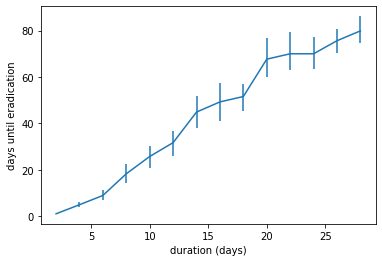

In [41]:
plt.errorbar(list(range(2, 30, 2)), 
             results['iteration']['mean'].values,
             np.array([results['iteration']['mean'].values - results['iteration']['low'].values,
                       results['iteration']['high'].values - results['iteration']['mean'].values]))
plt.xlabel('duration (days)')
plt.ylabel('days until eradication')
plt.show()

# Remote Execution

This part of the tutorial assumes that you have a Kubernetes cluster access configured. In other words the `~/.kube/config` file needs to be populated with the data that Kubernetes API can use to connect to a cluster. The exact details for how to do this will depend on your cloud service provider. For example, in order to start a cluster on GKE I would need to run the following command (or similar):

In [ ]:
!gcloud container clusters create easyvvuq

To use this functionality you would first need to create a Docker image for your simulation. There are many resource on how to do this. See for example [here](https://docs.docker.com/get-started/part2/). For your convenience below is the Dockerfile we have used when creating an EasyVVUQ image that will be used in his example. You also need to publish your Docker image to where it can be downloaded by the Kubernetes cluster. An obvious place is [Docker Hub](https://hub.docker.com/).

```
FROM ubuntu:latest

RUN apt-get update && \
    apt-get install -y python3-pip && \
    apt-get install -y git && \
    apt-get install -y tini && \
    pip3 install easyvvuq && \
    git clone https://github.com/UCL-CCS/EasyVVUQ.git

ENTRYPOINT ["tini", "--"]
```

After this, the only other bit of boring admin you need to do is to create a Kubernetes pod configuration. Again here is the one that was used in this tutorial:

```
apiVersion: v1
kind: Pod
metadata:
  name: epidemic
spec:
  restartPolicy: Never
  containers:
  - name: epidemic
    image: orbitfold/easyvvuq:latest
    command: ["/bin/sh", "-c"]
    args: ["python3 /EasyVVUQ/docs/epidemic/epidemic.py /config/example.json out.csv && cat out.csv"]
```

It will likely be the same for your simulation. Please note the image name, and the command that will be used to execute the simulation. In the current implementation your simulation needs to put all output to the standard output. So after creating the output CSV file we use `cat` to print it to the screen. Your way of doing this is likely to be different.

We have, so far, drawn 20 samples in our parameter sweep which has resulted in fairly wide error bars. We can shrink them by adding more samples. To this end will draw 80 more samples and create the corresponding input files.

In [62]:
campaign.draw_samples(60 * 14)
campaign.populate_runs_dir()

Now we call `apply_for_each_run_dir` with the `ExecuteKubernetes` action. This will submit the jobs to the Kubernetes cluster and the execution will automatically start.

In [63]:
statuses = campaign.apply_for_each_run_dir(
      uq.actions.ExecuteKubernetes('tutorial_files/kubernetes/epidemic.yaml', 
                                   ['epidemic_in.json'], 'output.csv'))

In [65]:
print(statuses.stats())

{'ready': 0, 'active': 0, 'finished': 840, 'failed': 0}


In [67]:
campaign.collate()
df = campaign.get_collation_result()

In [68]:
analysis = uq.analysis.EnsembleBoot(qoi_cols=["iteration"], groupby='ensemble', stat_func=np.mean, stat_name='mean')
campaign.apply_analysis(analysis)

In [69]:
results = campaign.get_last_analysis()
print(results)

         iteration                    
              mean       low      high
ensemble                              
0            1.165   1.08000   1.27000
1            4.475   4.08000   4.97000
2            9.375   8.38975  10.33000
3           17.185  15.51900  19.13025
4           24.300  21.82750  26.75050
5           31.220  28.13000  34.30125
6           45.910  42.61925  49.44025
7           50.160  46.93950  53.40075
8           56.230  52.89975  59.39075
9           65.415  62.40975  68.64050
10          65.850  62.80975  69.25100
11          68.880  65.91875  71.71000
12          71.400  68.25900  74.43125
13          75.855  73.48975  78.49000


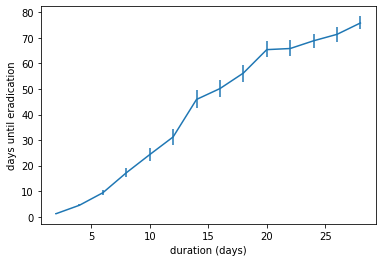

In [70]:
plt.errorbar(list(range(2, 30, 2)), 
             results['iteration']['mean'].values,
             np.array([results['iteration']['mean'].values - results['iteration']['low'].values,
                       results['iteration']['high'].values - results['iteration']['mean'].values]))
plt.xlabel('duration (days)')
plt.ylabel('days until eradication')
plt.show()

# Using Stochastic Collocation

In [71]:
params = {
    "grid_size": {"type": "float", "default": 10},
    "n": {"type": "float", "min": 1, "max": 100, "default": 20},
    "duration": {"type": "float", "min": 0, "max": 365, "default": 28},
    "mortality": {"type": "float", "min": 0.0, "max": 1.0, "default": 0.2}
}

campaign = uq.Campaign(name='epidemic_sc')
campaign.add_app(
    name="epidemic_sc",
    params=params,
    encoder=encoder,
    decoder=decoder,
    collater=collater)

In [72]:
vary = {
    "n": cp.DiscreteUniform(10, 100),
    "duration": cp.DiscreteUniform(7, 56),
    "mortality": cp.Uniform(0.0, 1.0),
}
sampler = uq.sampling.SCSampler(vary=vary, polynomial_order=5)
campaign.set_sampler(sampler)
campaign.draw_samples()

Received integer polynomial order, assuming isotropic grid


In [73]:
import os
campaign.populate_runs_dir()
campaign.apply_for_each_run_dir(
    uq.actions.ExecuteLocal(
        "{} epidemic_in.json output.csv".format(
            os.path.abspath('EasyVVUQ/docs/epidemic/epidemic.py')), 
            interpret="python3"))

In [ ]:
campaign.collate()
df = campaign.get_collation_result()
print(df)

And the analysis can be done with: :

In [ ]:
analysis = uq.analysis.SCAnalysis(sampler=sampler, qoi_cols=["iteration"])
campaign.apply_analysis(analysis)

In [ ]:
n = np.linspace(5, 100, 20)
duration = np.linspace(7, 50, 20)
mortality = 0.7
grid = np.meshgrid(n, duration, mortality)
z = np.array([analysis.surrogate('iteration', [grid[0].flatten()[i], grid[1].flatten()[i], mortality]) for i in range(n.shape[0] * duration.shape[0])]).flatten()
fig = plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.gca(projection='3d')
ax.set_zlim(0, 200)
ax.plot_trisurf(grid[0].flatten(), grid[1].flatten(), z)
ax.set_xlabel('n')
ax.set_ylabel('duration')
ax.set_zlabel('time')
plt.show()

Let us quickly check the correspondence of the surrogate model to the data we have collected during our parameter sweep experiment. What we're looking for is the curve should be within the confidence interval we have calculated.

In [ ]:
n = [20] * 14
duration = list(range(2, 30, 2))
mortality = [0.2] * 14

plt.plot(([analysis.surrogate('iteration', [n_, duration_, mortality_])[0] for n_, duration_, mortality_ in zip(n, duration, mortality)]))
plt.show()